## Classifying Variable Stars

Derive a set of features for a set of light curves of variable stars of known class. Train Machine Learning (ML) algorithms on a sample of this data set and then apply the algorithms to a set of light curves of unknown class to predict what type of variable star they are. Validate classified data.

**Second La Serena School for Data Science 2014**

Wilfred Tyler Gee  
Aracelly Herrera  
Carolina Núñez  
David Valenzuela  

In [1]:
import os.path
import sys
import urllib

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab as pl

from sklearn import svm, cross_validation, metrics
from sklearn.grid_search import GridSearchCV
from sklearn.naive_bayes import GaussianNB

import scipy.stats as stats

%matplotlib inline

from astroML.time_series import lomb_scargle

# Set some default font properties
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)
matplotlib.rcParams['font.size'] = 18

/home/wtgee/anaconda3/lib/python3.4/site-packages/astroML/time_series/periodogram.py:8: UserWarning: Using slow version of lomb_scargle. Install astroML_addons to use an optimized version
  warnings.warn("Using slow version of lomb_scargle. Install astroML_addons "


# Load Data

Our catalog data comes mostly from the Catalina Sky Survey (http://catalinadata.org).

In [2]:
# Load our matched data from the catalog
cat_data = 'catalog_data_final/matched_data.csv'
catalog = np.genfromtxt(cat_data, dtype=None, names=True, delimiter=',')

In [9]:
print("Columns in our catalog:")
for i, name in enumerate(catalog.dtype.names):
    print("{:2d} {}".format(i, name))

Columns in our catalog:
 0 InputID
 1 ID
 2 Mag
 3 Magerr
 4 RA
 5 Decl
 6 MJD
 7 Blend
 8 Catalina_Surveys_ID
 9 Numerical_ID
10 RA_J2000
11 Dec
12 V_mag
13 Period_days
14 Amplitude
15 Number_Obs
16 Var_Type
17 epoch_folding


# Setup our Features

In [10]:
def get_irq(rows):
    mags = rows['Mag']
    return np.percentile(mags, 75) - np.percentile(mags, 25)

def get_skew(rows):
    skew = stats.skew(rows['Mag'])    
    return skew

def get_median(rows):
    return np.median(rows['Mag'])

def build_features(save_file='features.txt', limit=False):
    """
    Builds our feature array. Loops over entire loaded catalog
    and creates one row per object. Current features include:
    
        * Period (from catalog)
        * Magnitude
        * Median
        * Amplitude
        * Skew
        * IQR
        
    If you want a limited set (for faster building), pass
    limit=True
    """

    obj_id_array = np.unique(catalog['ID'])

    features = np.zeros( (len(obj_id_array), 11) )

    # For each object
    for i in range(len(obj_id_array)):
        obj_id = obj_id_array[i]
    
        rows = catalog[(catalog['ID'] == obj_id)]
        
        if limit & i > 500:
            break
        
        features[i,0] = obj_id # Object ID
        features[i,1] = rows['Var_Type'][0] # Class
        features[i,2] = 0. # Predicted Class        
        features[i,3] = rows['RA'][0] # RA_J2000
        features[i,4] = rows['Decl'][0] # Dec
        features[i,5] = rows['Period_days'][0]  # Period
        features[i,6] = rows['Mag'][0]  # Mag
        features[i,7] = get_median(rows)  # Median
        features[i,8] = rows['Amplitude'][0]  # Amplitude
        features[i,9] = get_skew(rows)  # Skew
        features[i,10] = get_irq(rows)  # IQR
        
        # Save the files
        np.savetxt('features.txt', features, delimiter=',', 
           header="Object ID, Class, RAJ2000, Dec, Period, Mag, Amplitude, Median, Skew, IQR")
        
    return features

In [11]:
# Get our features. Either build them from scratch or load from file
# If we build them from scratch, we also pass in the file name to save.

features = None

features_file = 'features.txt'
if os.path.isfile(features_file):
    features = np.loadtxt(features_file, dtype=None, delimiter=",")
else:
    features = build_features(save_file=features_file)
    
# Display a row the features
features[0]

array([  1.00100400e+12,   3.00000000e+00,   0.00000000e+00,
         1.07909400e+01,  -2.64900000e+00,   2.18273000e-01,
         1.73200000e+01,   1.73000000e+01,   6.00000000e-01,
         1.24340797e+00,   2.20000000e-01])

## Separate Training and Test Data

We use a poor-man's version of the holdout method to split the initial set of data into training and test. During the training below, we use various methods to further split the training data into a training and validating set. Once we have trained and validated the data, we perform a prediction on the unlabeled test data.

In [12]:
# Start to build the table we will use

# For Training data, we want to get a certain amount of our
# table, we slice off a percentage
row_start = 0
row_end = len(features) - int(.25 * len(features))

# Our features table also contains meta information, so we slice
feature_column_start = 5

# Our collections of data to train and test
labeled_svm = features[row_start:row_end,feature_column_start:]
unlabeled_svm = features[row_end:,feature_column_start:]
test_all = features[row_end:]

# The correct classes corresponding to the training and test
classes = features[row_start:row_end,1]
unlabeled_classes = features[row_end:,1]

#labeled_svm, classes, unlabeled_svm, unlabeled_classes = cross_validation.train_test_split(
#    features[:,feature_column_start], features[:,1], test_size=1./3.)

Display the number of each class that we have in the training and test data

In [14]:
types = { 1: 'EW', 2: 'EA', 3: 'beta Lyrae'}

# How many of each Variable Type do we have
print("Type\t\t\tType\t\tNumber".format())
print("{}".format('-'*45))
for x in range(1,4):
    print("Labeled Class size:\t {:14s} {}".format(types[x],len(classes[classes == x])))
    print("Unlabelel Class size:\t {:14s} {}\n".format(types[x],len(unlabeled_classes[unlabeled_classes == x])))

Type			Type		Number
---------------------------------------------
Labeled Class size:	 EW             2888
Unlabelel Class size:	 EW             1036

Labeled Class size:	 EA             450
Unlabelel Class size:	 EA             85

Labeled Class size:	 beta Lyrae     37
Unlabelel Class size:	 beta Lyrae     4



# Figure out what training size is optimal

Here we use a set Test size but are trying to determine the optimal size for our training set. We loop over a number of sizes and determine the accuracy from each.

Here we do an initial split on the data and then try to predict with our classifier. Because of the simple split done with `train_test_split` we do not expect to achieve a high accuracy.

In [15]:
# Create our (linear) classifier
clf = svm.LinearSVC()
clf.fit(labeled_svm, classes)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='l2', multi_class='ovr', penalty='l2',
     random_state=None, tol=0.0001, verbose=0)

In [16]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split (labeled_svm, classes, test_size=1./3.)

print("training set = {} {}".format(X_train.shape, y_train.shape))
print("test size = {} {}".format(X_test.shape, y_test.shape))

clf.fit(X_train, y_train)
pred_class = clf.predict(X_test)
N_match = (pred_class == y_test).sum()
print("N_match = {}".format(N_match))
acc = 1. * N_match / len(pred_class)
print("Accuracy = {}".format(acc))

training set = (2250, 6) (2250,)
test size = (1125, 6) (1125,)
N_match = 1034
Accuracy = 0.9191111111111111


Here we use a slightly more intelligent split of the labeled data (with `StratifiedShuffleSplit`) to attempt to achieve a higher accuracy

In [19]:
ss = cross_validation.StratifiedShuffleSplit(classes, 5, test_size = 1./3.)
scores = cross_validation.cross_val_score(clf, labeled_svm, classes, cv=ss)
print("Accuracy = {} +- {}".format(scores.mean(),scores.std()))

Accuracy = 0.9216000000000001 +- 0.0026006646823693714


### See if there is a better training size that we can use

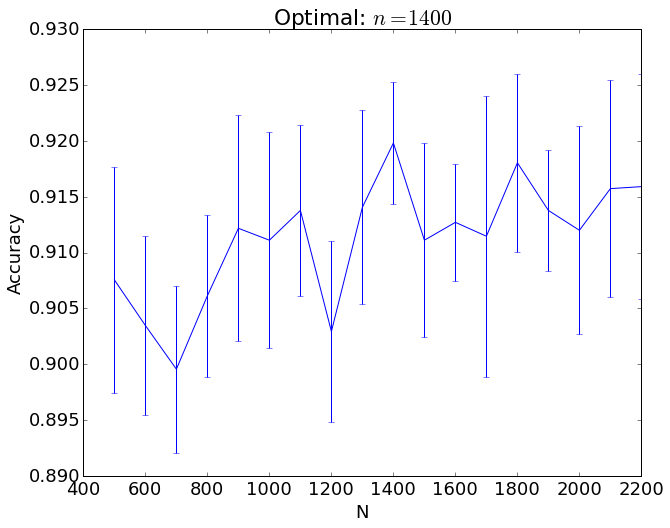

In [20]:
step = 100
stop = int(len(labeled_svm) * (2./3.))
Ns = np.arange(500, stop , step)

#print "Attempted N sizes = {}".format(Ns)
scores = np.zeros(len(Ns))
stds = np.zeros(len(Ns))
for i in range(len(Ns)):
    N = Ns[i]
    ss = cross_validation.StratifiedShuffleSplit(classes, 5, test_size = 1./3., train_size = N)
    scores_i = cross_validation.cross_val_score(clf, labeled_svm, classes, cv=ss)
    scores[i] = scores_i.mean()
    stds[i] = scores_i.std()

    
# Get our optimal n
optimal_n = Ns[np.argmax(scores)]
    
# Plot our results, including optimal n
pl.clf()
fig = pl.figure()
ax = fig.add_subplot(1,1,1)
ax.errorbar (Ns, scores, yerr = stds)
ax.set_xlabel("N")
ax.set_ylabel("Accuracy")
pl.title("Optimal: $n={}$".format(optimal_n))    
pl.show()

# Figure out the optimal C

As an exercise, we compute the optimal $C$ scaling parameter for the equation below. We are still using the linear SVC so this is mostly an example of how one would compute this parameter. A graph of the possible $C$ values are displayed as well as the best estimator. 

$\min_{\bf{w}, \xi, b}\left\{\frac{1}{2}||\bf{w}||^2 + C\sum_{i=1}^n\xi_i\right\}$
subject to $y_i(\bf{w\cdot x}_i-b)\geq 1-\xi_i$, $\xi_i\geq 0$

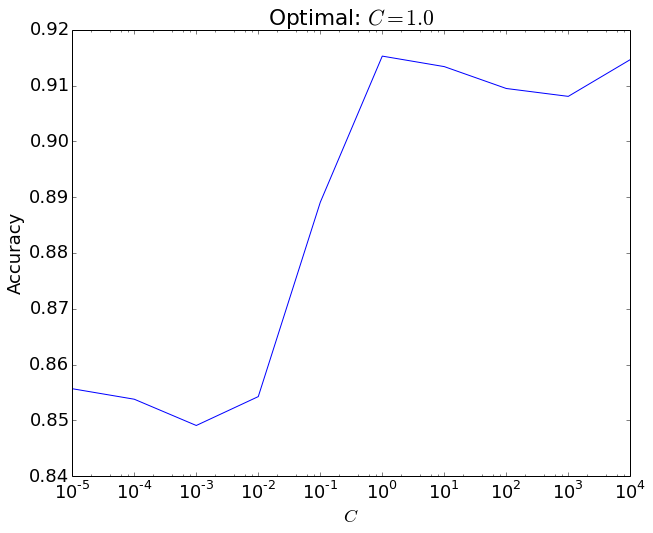

The best classifier is: LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss=l2, multi_class=ovr, penalty=l2,
     random_state=None, tol=0.0001, verbose=0)


In [13]:
C_range = 10. ** np.arange(-5, 5)
param_grid = dict(C=C_range)

# We use a test_size of None because we already figured out our optimal train_size
ss = cross_validation.StratifiedShuffleSplit(classes, 5, test_size = None, train_size = optimal_n)

grid = GridSearchCV(svm.LinearSVC(), param_grid=param_grid, cv=ss)
grid.fit (labeled_svm, classes)

# plot the scores of the grid grid_scores_ contains parameter settings and scores
# grid_scores_ contains parameter settings and scores                                                 
score_dict = grid.grid_scores_
# We extract just the scores
scores = [x[1] for x in score_dict]

pl.clf()
fig = pl.figure()
ax = fig.add_subplot(1,1,1)
ax.plot (C_range, scores)
ax.set_xscale("log")
ax.set_xlabel("$C$")
ax.set_ylabel("Accuracy")
ax.set_title("Optimal: $C={}$".format(grid.best_estimator_.C))
pl.show ()

print "The best classifier is: {}".format(grid.best_estimator_)

### Support Vector Classification (SVC)

We use the sklean.svm.svc module with a few different kernels to attempt some fits.

The equation governing this classification is:

$K(\bf{x}, \bf{x}') = e^{-\gamma||\bf{x}-\bf{x}'||^2}$
   
Threfore we need to obatin both $C$ and $\gamma$, so we test a range of values and create a heat-map to show optimal.

### Determine Best Kernel Classifier

Run through the different kernels for an SVC to determine the best. Possible kernels are:
    
* linear
* poly 
* rbf
* sigmoid
* precomputed
    
We perform an exhaustive grid search across all the kernels with a range of different values. We compute these separately so that we can then compare each with an ROC. The grid search would handle this internally if we ran them all together but we want to generate an ROC plot so we do it separate.

#### Get the optimal SVC

Here we define the parameters for each of the kernel types and then run them through an exhaustive grid search. This is similar to the examples above where we ran through a list of $C$ and $\gamma$ values but here the `GridSearchCV` takes care of all the details. This gets us our optimal classifier based on this exhaustive search.

One area of uncertainty is the selection of our ranges below. We lifted the $C$ and $\gamma$ ranges from Guillermo's Hands-On (_todo: get reference_) and just copied that over for the coefficient range. We totall guessed at the degree range and would need to explore that more.

In [14]:
def get_optimal_svc(param_grid=list(), plot=False):
    
    # Do the grid search
    grid = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=ss)
    grid.fit (labeled_svm, classes)
    
    if plot:
        score_dict = grid.grid_scores_
        
        # We extract the scores
        scores = [x[1] for x in score_dict]
        scores = np.array(scores).reshape(len(C_range), len(gamma_range))

        # Make a nice figure
        pl.figure(figsize=(8, 6))
        pl.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.95)
        pl.imshow(scores, interpolation='nearest', cmap=pl.cm.gist_heat)
        pl.xlabel('$\gamma$')
        pl.ylabel('$C$')
        pl.title('Heatmap for optimal: $C={}$ and $\gamma={}$\n'.format(grid.best_estimator_.C, grid.best_estimator_.gamma))
        pl.colorbar()
        pl.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
        pl.yticks(np.arange(len(C_range)), C_range)
        pl.show()

    print "The best classifier for this run is: {}".format(grid.best_estimator_)
    return grid.best_estimator_

In [42]:
# Setup our ranges
C_range = 10. ** np.arange(-4, 4)
gamma_range = 10. ** np.arange(-4, 4)
deg_range = np.arange(1, 3)
coef_range = 10. ** np.arange(-4, 4)

param_grids = [
    #{ 'C': C_range, 'kernel': ['linear'] },
    #{ 'C': C_range, 'gamma': gamma_range, 'degree': deg_range, 'coef0': coef_range, 'kernel': ['poly'] },
    { 'C': C_range, 'gamma': gamma_range, 'kernel': ['rbf'] },
    #{ 'C': C_range, 'gamma': gamma_range, 'coef0': coef_range, 'kernel': ['sigmoid'] },
    
    { 'kernel': ['linear'] },
    { 'kernel': ['poly'] },
    { 'kernel': ['sigmoid'] },
]

best_svcs = list()

# Run the param_grid one at a time (to compare ROC below)
# Get the best clf for each kernel type
for param_grid in param_grids:
    print "{}...".format(param_grid.get('kernel'))
    clf = get_optimal_svc(param_grid=param_grid, plot=False)
        
    param_grid['clf'] = clf
    
    best_svcs.append(param_grid)

The best classifier for this run is: SVC(C=1000.0, cache_size=200, class_weight=None, coef0=0.0, degree=3,
  gamma=0.01, kernel=rbf, max_iter=-1, probability=False,
  random_state=None, shrinking=True, tol=0.001, verbose=False)
The best classifier for this run is: SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel=linear, max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
The best classifier for this run is: SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel=poly, max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
The best classifier for this run is: SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel=sigmoid, max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


### Classify

We have obtained our best classifiers above, so we classify the data with each. We will then compare how these classifiers worked with a ROC.

First we defined our `classify` and `compute_roc` functions and then use them below.

In [44]:
def classify(clf=None, save_output=False):

    # Use the best estimator from above and fit with our trained data and classes
    clf.fit (labeled_svm, classes)

    # Attempt a prediction
    predicted_classes = clf.predict(unlabeled_svm)

    if save_output:
        # Creating an array to hold our new predicted values
        out = np.zeros ((len(pred_class), unlabeled_svm.shape[1] + 1))
        out[:,:unlabeled_svm.shape[1]] = unlabeled_svm[:][:]
        out[:, -1] = predicted_classes [:]

        classifications_filename = "classifications_predicted_{}.csv".format(clf.kernel)
        
        # Save our new classifications out to a file
        np.savetxt(classifications_filename, out, delimiter=",")
    
    return predicted_classes

In [17]:
def compute_roc(predicted_classes=None):
    # Get our mask array of true values
    predicted_correct_mask = np.array(unlabeled_classes == predicted_classes)

    # Get the scores from the classifier
    y_score = clf.decision_function(unlabeled_svm)

    # Perform the ROC to get false-positives and true-positives
    fpr, tpr, thresh =  metrics.roc_curve(predicted_correct_mask,y_score[:,0])
    roc_auc = metrics.auc(fpr,tpr)
    
    return fpr, tpr, roc_auc

In [46]:
# Loop over each SVC type, classify, then compute the ROC
for kernel in best_svcs:
    clf = kernel.get('clf')

    print "{} ".format(clf.kernel)

    # Do the actual classifying
    print "\t Classifying..."
    pred_class = classify(clf)
    
    # Compute the ROC
    print "\t Computer ROC..."
    fpr, tpr, auc = compute_roc(pred_class)
    
    # Store the predicted classes and the ROC params
    kernel['predicted_classes'] = pred_class
    kernel['fpr'] = fpr
    kernel['tpr'] = tpr
    kernel['auc'] = auc    

rbf 
	 Classifying...
	 Computer ROC...
linear 
	 Classifying...
	 Computer ROC...
poly 
	 Classifying...
	 Computer ROC...
sigmoid 
	 Classifying...
	 Computer ROC...


### ROC Curve
Here we determine which classifier was the "best" via an ROC Curve.

_NOTE: We could have just performed the exhaustive grid search above and it would have automatically compared all of these and output the absolute best, but because we wanted to generate an ROC we performed them separately._

In [48]:
def plot_roc(classifier_list=None):
    # Plot the ROC for each kernel type
    pl.clf()
    fig = pl.figure()
    ax = fig.add_subplot(1,1,1)

    # Add a line for each kernel
    for classifier in classifier_list:
        fpr = classifier['fpr']
        tpr = classifier['tpr']
        auc = classifier['auc']
        ax.plot (fpr, tpr, label='{} (area = {:0.2f})'.format(classifier.get('kernel')[0], auc))

    plt.legend(loc=4)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    pl.show ()

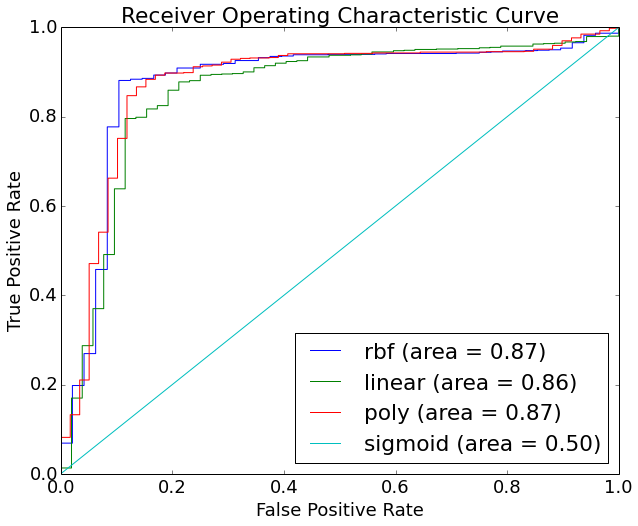

In [49]:
plot_roc(classifier_list=best_svcs)

After looking at the ROC curve above, we select the best estimator based on hightest area under the curve.

In [76]:
aucs = np.array([x.get('auc') for x in best_svcs])

best_estimator = best_svcs[np.where(aucs.max())[0][0]]

predicted_classes = best_estimator.get('predicted_classes')

# Put the predicted class into the original data
test_all[:,2] = predicted_classes

In [78]:
# Save predicted features
np.savetxt('predicted_features.csv', test_all, delimiter=',')

### Analysis 
Show some stats on the estimator with the best fit

In [79]:
test_all = np.loadtxt('predicted_features.csv', dtype=None, delimiter=",")

In [80]:
# Pull the predicated class out
pred_class = test_all[:,2]
unlabeled_classes = test_all[:,1]

diff_index = np.where(pred_class != unlabeled_classes)

length_of_diff = len(diff_index[0])
length_of_unlabeled = len(unlabeled_classes)

diff_percentage = 1 - (float(length_of_diff)/float(length_of_unlabeled))

print "{:.2%}".format(diff_percentage)

95.73%


In [81]:
features_dict = {
'ID': 0,
'Class': 1,
'Predicted Class': 2,
'RA_J2000': 3,
'Dec': 4,
'Period': 5,
'Mag': 6,
'Median': 7,
'Amplitude': 8,
'Skew': 9,
'IQR': 10,
}
test_all[0]

array([  1.13501406e+12,   1.00000000e+00,   1.00000000e+00,
         4.43918500e+01,   3.55899900e+01,   2.91636000e-01,
         1.78800000e+01,   1.79300000e+01,   4.70000000e-01,
         1.10222752e-01,   3.22500000e-01])

In [82]:
# Get all misclassified objects index
diff_index = np.where(test_all[:,1] != test_all[:,2])

In [83]:
def plot_lightcurve(rows, predicted_class):
    Mag = rows["Mag"]
    MJD = rows["MJD"]
    T = rows["Period_days"][0]
    time = rows["epoch_folding"]
    cls = rows["Var_Type"][0]
    
    index=sorted(range(len(time)), key=lambda k: time[k])
    Mag_new=Mag[index]

    double_mag = np.array(list(Mag_new)*2)
    x = [float(x)/len(Mag_new)for x in np.arange(0,len(double_mag))]

    plt.figure()
    plt.scatter(x, double_mag, alpha=0.25)

    plt.ylim(double_mag.max() + 0.5, double_mag.min() - 0.5)
    plt.xlim(0.0,2.0)
    
    plt.xlabel("Phase")
    plt.ylabel("Magnitue")
    
    plt.title("Class: {} Predicted Class: {}".format(int(cls), int(predicted_class)))

In [106]:
# Generate a light curve for a mis-classified object

class_table = np.zeros((3,3))

for i in range(len(diff_index[0])):
    # Get an object that was misclassified
    obj_idx = diff_index[0][i]
    obj = test_all[obj_idx]
    obj_id = obj[0]
    
    predicted_class = test_all[obj_idx,2]
    actual_class = test_all[obj_idx,1]
    
    row = int(actual_class) - 1
    col = int(predicted_class) - 1
    
    class_table[row][col] += 1
    
    # Get all the observations
    #obj_rows = catalog[np.where(catalog['ID'] == obj_id)]


    #plot_lightcurve(obj_rows, predicted_class)

print class_table

[[  0.  26.   0.]
 [ 18.   0.   0.]
 [  2.   2.   0.]]


In [137]:
types = { 1: 'EW', 2: 'EA', 3: 'beta Lyrae'}

# How many of each Variable Type do we have
print "Type\t\tTotal Number\tNumber Misclassified\tMisclassified Percent".format()
print "{}".format('-'*77)
for x in range(1,4):

    total_num = len(unlabeled_classes[unlabeled_classes == x])
    total_miss = len(unlabeled_classes[unlabeled_classes == x]) # FIXME
    percent = float(class_table[x-1].sum()) / total_num
    
    print "{:14s}\t{:12d}\t{:20d}\t{:21.2%}".format(
        types[x],total_num, total_miss, percent)

Type		Total Number	Number Misclassified	Misclassified Percent
-----------------------------------------------------------------------------
EW            	        1036	                1036	                2.51%
EA            	          85	                  85	               21.18%
beta Lyrae    	           4	                   4	              100.00%


If anything, we would expect the type 3 class (beta Lyrae) to be classified as a type 1 so it is interesing to see that they split evenly. However, we have such low numbers that it's probably not worth further analysis at this point.

#### Sample plots

Plot an example of the different types (1 and 2) for three features. Incorrectly classified types are highlighted

In [88]:
# Get our indices for the correctly and incorrectly classified types

correct_idx = test_all[:,1] == test_all[:,2]
incorrect_idx = test_all[:,1] != test_all[:,2]

In [103]:
# Separate the correctly classified types
type_1_correct = test_all[test_all[correct_idx,1] == 1]
type_2_correct = test_all[test_all[correct_idx,1] == 2]
type_3_correct = test_all[test_all[correct_idx,1] == 3]

# Separate the incorrectly classified types
type_1_incorrect = test_all[test_all[incorrect_idx,1] == 1]
type_2_incorrect = test_all[test_all[incorrect_idx,1] == 2]
type_3_incorrect = test_all[test_all[incorrect_idx,1] == 3]

print len(type_1_correct)
print len(type_2_correct)
print len(type_3_correct)

print len(type_1_incorrect)
print len(type_2_incorrect)
print len(type_3_incorrect)

1010
67
0
26
18
4


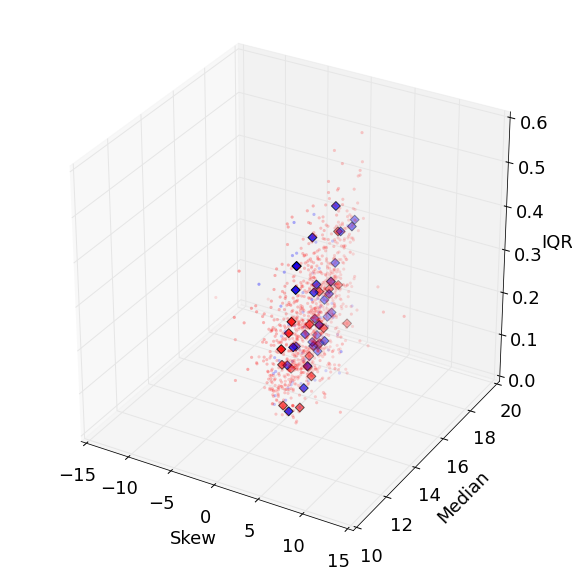

In [86]:
pl.clf()
fig = pl.figure(figsize = (10, 10))
ax = fig.gca(projection='3d')

plot_list = ['Skew', 'Median', 'IQR']

# Correct class type indexes
type_1_idx = np.where(test_all[correct_idx, 1] == 1)
type_2_idx = np.where(test_all[correct_idx, 1] == 2)
type_3_idx = np.where(test_all[correct_idx, 1] == 3)

# Incorrect class type indexes
type_1_idx_x = np.where(test_all[incorrect_idx, 1] != 1)
type_2_idx_x = np.where(test_all[incorrect_idx, 1] != 2)
type_3_idx_x = np.where(test_all[incorrect_idx, 1] != 3)

# Type 1 Correct
param1 = test_all[type_1_idx,features_dict.get(plot_list[0])]
param2 = test_all[type_1_idx,features_dict.get(plot_list[1])]
param3 = test_all[type_1_idx,features_dict.get(plot_list[2])]
ax.scatter(param1, param2, param3, marker='.', c='r', edgecolors='None', alpha=0.35, s=40, label="Type 1 Correct")

# Type 2 Correct
param1 = test_all[type_2_idx,features_dict.get(plot_list[0])]
param2 = test_all[type_2_idx,features_dict.get(plot_list[1])]
param3 = test_all[type_2_idx,features_dict.get(plot_list[2])]
ax.scatter(param1, param2, param3, marker='.', c='b', edgecolors='None', alpha=0.35, s=40, label="Type 2 Correct")

# Type 1 Not Correct
param1 = test_all[type_1_idx_x,features_dict.get(plot_list[0])]
param2 = test_all[type_1_idx_x,features_dict.get(plot_list[1])]
param3 = test_all[type_1_idx_x,features_dict.get(plot_list[2])]
ax.scatter(param1, param2, param3, marker='D', c='r', alpha=0.99, s=40,  label="Type 1 Not Correct")

# Type 2 Not Correct
param1 = test_all[type_2_idx_x,features_dict.get(plot_list[0])]
param2 = test_all[type_2_idx_x,features_dict.get(plot_list[1])]
param3 = test_all[type_2_idx_x,features_dict.get(plot_list[2])]
ax.scatter(param1, param2, param3, marker='D', c='b', alpha=0.99, s=40, label="Type 2 Not Correct")

#ax.legend(loc="best")
ax.set_xlabel (plot_list[0])
ax.set_ylabel (plot_list[1])
ax.set_zlabel (plot_list[2])

pl.show()

#### HOWEVER,

This is not correct. When we tried to plot light curves from the sample points listed above, we realized that we were indexing incorrectly above:

    # Get incorrect indices
    incorrect_idx = test_all[:,1] != test_all[:,2]
    type_1_idx_x = np.where(test_all[incorrect_idx, 1] == 1)
    type_2_idx_x = np.where(test_all[incorrect_idx, 1] == 2)
    type_3_idx_x = np.where(test_all[incorrect_idx, 1] == 3)
    
So, it turns out our comment is correct. :) Essentially, we are highlighting the correct _number_ of misclassified points, but then pulling random points from our original list.

#### Example Correct Light Curve

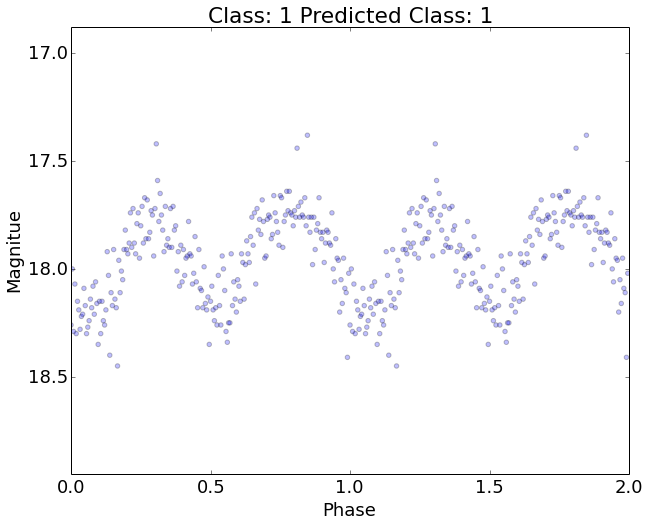

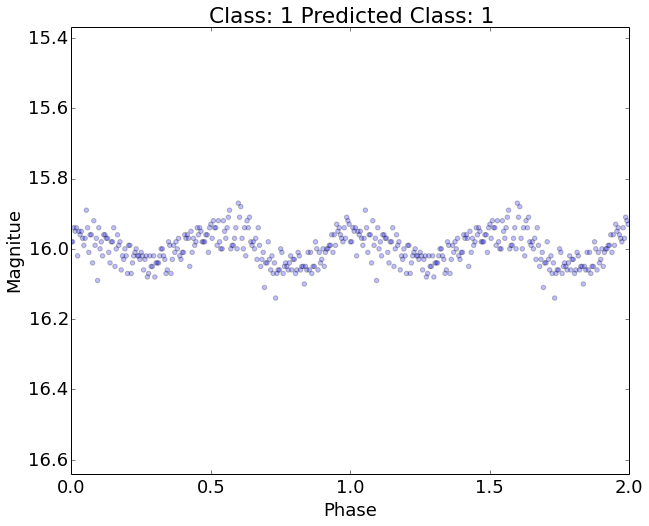

In [87]:
# Type 1
obj_idx = type_1_idx[0][0]
obj = test_all[obj_idx]
obj_id = obj[0]
    
predicted_class = test_all[obj_idx,2]
    
# Get all the observations
obj_rows = catalog[np.where(catalog['ID'] == obj_id)]

plot_lightcurve(obj_rows, predicted_class)

# Type 2
obj_idx = type_2_idx[0][0]
obj = test_all[obj_idx]
obj_id = obj[0]
    
predicted_class = test_all[obj_idx,2]
    
# Get all the observations
obj_rows = catalog[np.where(catalog['ID'] == obj_id)]

plot_lightcurve(obj_rows, predicted_class)

### TODO

- **Data**
    - More data 
        - all types, but especially type 3 (EB - beta Lyrae)
        - other catalogs
    - Data split
        - Try random sampling, k-fold cross validation, bootstrap
        - Test / Validation Split
            - We used a linear kernel to determine the optimal split size but eventually used the RBF kernel as our best classifier. Could have explored different split sizes with appropriate kernel
    - Data scrubbing
        - e.g. How many periods do we have?
        - How many observations do we have?
- **Features**
    - More features
        - colors
    - Better feature selection
        - Use the lomb-scargle for period
- **Classifier**
    - Better parameter selection for various kernels
    - Explore different classifier models (random forest, etc)
    - Compare against astroML (unless it just wraps sklearn)
- **Performance**
    - Use the HPC to run the kernel loop
- **Analysis**
    - More and better analysis on incorrectly classified objects (outliers)
        - Error analysis all along the way
        - Confusion matrix
    - Pretty plots ([seaborn](http://web.stanford.edu/~mwaskom/software/seaborn/))
    - Confusion matrix table improvement
    - **Grok More**